In [1]:
from PIL import Image
import os
import pickle
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

In [2]:
def adaptive_histeq(img_gray):
      clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(8,8))
      final_img = clahe.apply(img_gray) 
      return final_img

In [3]:
def simple_processing_clahe(img):
    
    gray = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    kernel = cv2.getStructuringElement(1,(7,7))
    closing = cv2.morphologyEx(gray,cv2.MORPH_CLOSE,kernel, iterations = 2)
    imgeq = cv2.equalizeHist(gray)
    clahe=adaptive_histeq(gray)
    
    return clahe
    

In [4]:
def preprocessing_lab_histeq(img):
        blur = cv2.GaussianBlur(img,(5,5),0)
        
        
        # https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv
        lab= cv2.cvtColor(blur, cv2.COLOR_BGR2LAB)
        l_channel, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl = clahe.apply(l_channel)
        limg = cv2.merge((cl,a,b))
        enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        
        #enhanced_img = cv2.convertScaleAbs(enhanced_img, alpha=1.3, beta=-40)

        
        gray = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY )
        gray=cv2.equalizeHist(gray)
        
        #gray = cv2.GaussianBlur(gray,(5,5),0)
        
        return gray

In [5]:
def preprocessing_enhance_thresh(img):
     # Step 1
        blur = cv2.GaussianBlur(img,(13,13),0)
        
        
        # Step 3
        # https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv
#         lab= cv2.cvtColor(blur, cv2.COLOR_BGR2LAB)
#         l_channel, a, b = cv2.split(lab)
#         clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#         cl = clahe.apply(l_channel)
#         limg = cv2.merge((cl,a,b))
#         enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

        enhanced_img = cv2.convertScaleAbs(blur, alpha=1.8, beta=10)

        # Step 4
        gray = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY )
        gray=cv2.equalizeHist(gray)
        edges = cv2.Canny(gray,0,255)
        
        edges_inverse = cv2.bitwise_not(edges)
        

            
        # Step 5
        
        T,imgt = cv2.threshold(gray,np.median(gray)-1,255,cv2.THRESH_BINARY)

    
        return gray

In [6]:
def hsv_histeq(img_gray):
    value=90
    bgr = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    imgeq=cv2.equalizeHist(v)

    final_hsv = cv2.merge((h, s, imgeq))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

In [7]:
# https://github.com/sunnyshah2894/DigitalHairRemoval

def remove_hairs(img):
    kernel = cv2.getStructuringElement(1,(17,17))
    grayScale = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    edges = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    ret,thresh = cv2.threshold(edges,10,255,cv2.THRESH_BINARY)
    dst = cv2.inpaint(img,thresh,1,cv2.INPAINT_TELEA)
    
    return edges, thresh, dst

In [8]:
def normalize_red_band(img):
    blank_img = img
    linhas,colunas,channels=img.shape
    for l in range(linhas):
          for c in range(colunas):
                ur,ug,ub = img[l][c]
                norm = ur/math.sqrt(ur**2+ug**2+ub**2)
                blank_img[l][c] = (norm,ug,ub)
    
    return blank_img

In [9]:
def preprocessing_hair_rnorm_histeq(img):

        edges, thresh, dst = remove_hairs(img)
        r_norm = normalize_red_band(dst)
        gray = cv2.cvtColor( r_norm, cv2.COLOR_RGB2GRAY )
        imgeq = hsv_histeq(gray)
        
        return imgeq
        

In [33]:
def apply_preprocessing(src_dir, dest_dir, func):
    imgs_list = []
    with open(dest_dir,"wb") as dest:
        for f in os.listdir(src_dir):
            if f.endswith(".png"):
                filename = '../../data/images/'+f
                img = cv2.imread(filename)[:,:,::-1]
                processed = func(img)
                imgs_list.append((processed,f))
                
        pickle.dump(imgs_list,dest)

            
            
    

In [34]:
def load_images(src_dir, pickle_file, func):
        try:
            with open(pickle_file,"rb") as f:
                recovered_list = pickle.load(f)
        except:
            apply_preprocessing(src_dir, pickle_file, func)       
            with open(pickle_file,"rb") as f:
                recovered_list = pickle.load(f)
                
        return recovered_list
            
            


In [54]:
def create_img_folder(recovered_list, dest_path):
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)
    for img, name in recovered_list:
        cv2.imwrite(dest_path+name, img)

In [56]:
folder_path = "../../data/images/preprocessing_3/"
create_img_folder(recovered_list, folder_path)

In [69]:
SOURCE_DIRECTORY = "../../data/images"

pickle_file = "../../data/images/preprocessing_1.pickle"
recovered_list = load_images(SOURCE_DIRECTORY, pickle_file, simple_processing_clahe)        


In [70]:
recovered_list[0][1]

'PAT_1000_31_620.png'

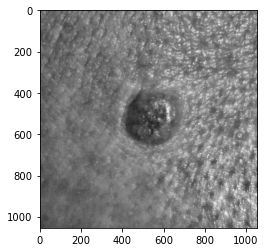

In [71]:
plt.imshow(recovered_list[400][0], cmap='gray', vmin = 0, vmax = 255)

In [72]:
folder_path = "../../data/images/preprocessing_1/"
create_img_folder(recovered_list, folder_path)

In [74]:
pickle_file = "../../data/images/preprocessing_2.pickle"
recovered_list = load_images(SOURCE_DIRECTORY, pickle_file, preprocessing_lab_histeq)        


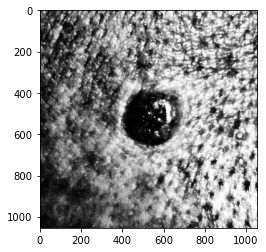

In [75]:
plt.imshow(recovered_list[400][0], cmap='gray', vmin = 0, vmax = 255)

In [76]:
folder_path = "../../data/images/preprocessing_2/"
create_img_folder(recovered_list, folder_path)

In [52]:
pickle_file = "../../data/images/preprocessing_3.pickle"
recovered_list = load_images(SOURCE_DIRECTORY, pickle_file, preprocessing_enhance_thresh)        


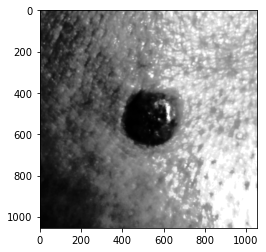

In [53]:
plt.imshow(recovered_list[400][0], cmap='gray', vmin = 0, vmax = 255)

In [ ]:
pickle_file = "../../data/images/preprocessing_4.pickle"
recovered_list = load_images(SOURCE_DIRECTORY, pickle_file, preprocessing_hair_rnorm_histeq)        

In [50]:
recovered_list[0].shape

(609, 609)